In [1]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle

In [2]:
def load_ames_housing():
    df = fetch_openml(name = 'house_prices', as_frame = True)
    x = df.data
    y = df.target
    
    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]
    
    x = x.loc[: , features]
    x,y = shuffle(x,y,random_state=43)
    
    x = x.iloc[:600]
    y = y.iloc[:600]
    
    return x, np.log1p(y) # 종속 변수 로그 변환 적용

x,y = load_ames_housing()

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include = np.number)

In [4]:
cat_selector(x)  # 범주형 변수 셀렉터

['HeatingQC',
 'Street',
 'Heating',
 'MasVnrType',
 'Foundation',
 'ExterQual',
 'Condition2',
 'GarageType',
 'HouseStyle',
 'MiscFeature']

In [5]:
num_selector(x)  # 수치형 변수 셀렉터

['YrSold',
 'YearRemodAdd',
 'BsmtUnfSF',
 'MasVnrArea',
 'MSSubClass',
 'GarageCars',
 'OverallQual',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'MoSold']

In [6]:
# 사용 모델에 다른 전처리 프로세서 생성 (1)

from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder 

# ordinalencoder와 labelencoder의 주요 차이는 차원 증가 여부, 순서 보존에 따라 다르다.
# ordinalencoder는 순서 특성이 있는 범주형 변수에 적용한다. 즉, high, middel, low 라면 이들 간의 순서(차이)를 유지하는 특징이 있다.

cat_tree_processor = OrdinalEncoder(
        handle_unknown = 'use_encoded_value',
        unknown_value = -1,
        encoded_missing_value=-2
)

num_tree_processor = SimpleImputer(strategy='mean',
                                   add_indicator=True)

tree_processor = make_column_transformer(
            (num_tree_processor, num_selector),
            (cat_tree_processor, cat_selector)
)

tree_processor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e6b0>),
                                ('ordinalencoder',
                                 OrdinalEncoder(encoded_missing_value=-2,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e980>)])

In [10]:
# 사용 모델에 다른 전처리 프로세서 생성 (2)

from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_inear_processor = OneHotEncoder(handle_unknown='ignore')

num_linear_processor = make_pipeline(
    StandardScaler(), num_tree_processor
)  # 순서대로 처리 (스케일러 -> num_tree_processor)

linear_preprocessor = make_column_transformer(
        (num_linear_processor, num_selector),
        (cat_inear_processor , cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e6b0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e980>)])

In [11]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(
        linear_preprocessor, LassoCV()
)

lasso_pipeline

# Lasso 이용한 Single 모델 파이프라인

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e6b0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e980>)])),
                ('lassocv', LassoCV())])

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(
        tree_processor, RandomForestRegressor(random_state=1)
)

rf_pipeline

# 랜덤포레스트 이용한 Single 모델 파이프라인

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e6b0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e980>)])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=1))])

In [19]:
import lightgbm as lgb

lgb_pipeline = make_pipeline(
    tree_processor, lgb.LGBMRegressor(random_state = 2, verbose = -1) # 스태킹 사용 방법을 위한 코드라 굳이 파라미터 튜닝 진행하지 않음
)

lgb_pipeline

# lightGBM 이용한 Single 모델 파이프라인

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e6b0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e980>)])),
                ('lgbmregressor', LGBMRegressor(random_state=2, verbose=-1))])

In [27]:
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import VotingRegressor, StackingRegressor

estimator = [
    ('lgb',lgb_pipeline),
    ('lasso', lasso_pipeline),
    ('rf ', rf_pipeline)
]
    
final_estimator = StackingRegressor(estimators=estimator,
                                   final_estimator= RidgeCV())

# 각 모델의 예측 결과를 생성한 이후 최종 사용할 모델로 Ridge 사용

In [28]:
final_estimator # 여러 Single 모델의 예측 결과 값을 이용하여 최종 결과 예측

StackingRegressor(estimators=[('lgb',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('simpleimputer',
                                                                                 SimpleImputer(add_indicator=True),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e6b0>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),...
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e6b0>),
                                                                                ('ordinalencoder',
                                                                                 OrdinalEncoder(encoded_missing_value=-2,
                                                                                                handle_unknown='use_encoded_value',
                                                                                                unknown_value=-1),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7c663478e980>)])),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=1))]))],
                  final_estimator=RidgeCV())

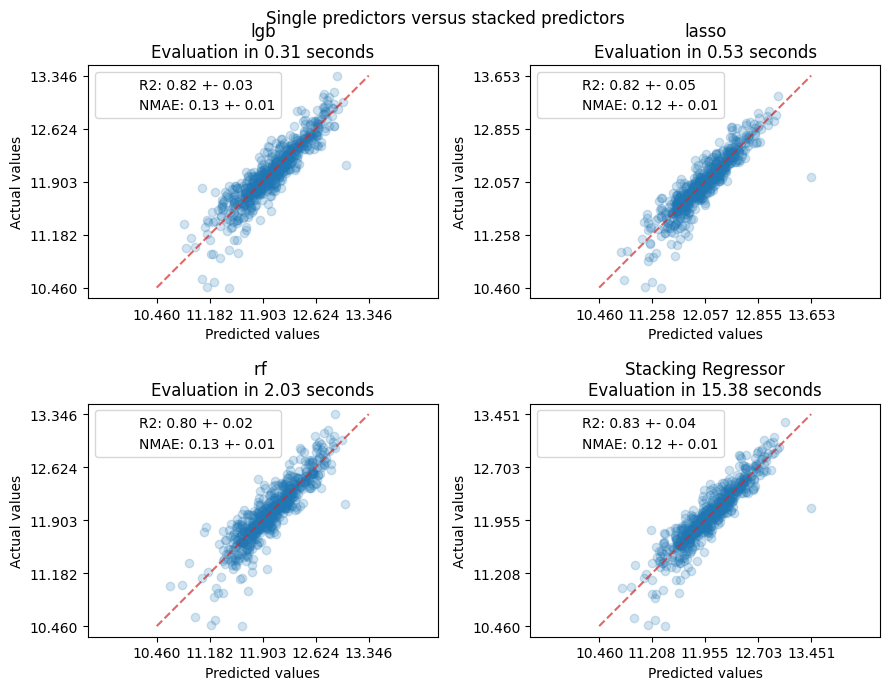

In [29]:
import time
import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimator + [("Stacking Regressor", final_estimator)]
):
    scorers = {"R2": "r2", "NMAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, x, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, x, y, n_jobs=-1, verbose=0)
    
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
# neg_mean_absolute_erorr를 사용하는 이유는 cross_validate, GridSearchCV에서 사용되는 scoring 옵션은 클수록 좋은 성능이라고 여김
# 그러나 MAE는 작을 수록 좋은 성능을 의미하기 때문에 일부러 -를 붙여서 scoring에 사용(음수의 경우 0에 가까울 수록 좋은 성능을 의미하기 때문)

# 위 시각화 결과에서 양수로 나온 이유는 중간에 np.abs()를 사용했기 때문

In [ ]:
# 성능은 미세하게 stacking 모델이 잘 나왔지만  소요 시간 측면에서는 Single 모델보다 훨씬 느린 속도이기 때문에 
# 상황에 맞게 적절한 모델 선택이 필요해보인다.